# 2D species transport (Part II): Implementation of advection-diffusion equation

Following the derivation and discussion of the advection-diffusion PDE last week, we will now implement the complete Equation (see Eq. 1) using the finite difference method (FDM).

$\frac{\partial C}{\partial t} = \underbrace{\mathbf{D} \left[ \frac{\partial ^2C}{\partial x^2} +\frac{\partial ^2C}{\partial y^2} \right]}_{\text{Diffusion}} \underbrace{- v_x \frac{\partial C}{\partial x} - v_y \frac{\partial C}{\partial y}  }_{\text{Advection}}$ (Equation 1)

The term $D$ represents the hydrodynamic dispersion coefficient and $C$ the species concentration (alternatively, we could also transport any other scalar value such as mass, temperature or energy). Equation 1 comprises a 2D diffusion term and a 2D advection term, whereby we simplify our model by assuming homogeneous and isotropic spatial distributions of $D$ and $v$. The flow velocity $\mathbf{v}$ is a component of the advection term as discussed in the previous lecture. Another simplification used in the present model is the assumption of the effective porosity $n_e = 1$, so that $\mathbf{q} = \mathbf{v}$. Flow velocity is given in the present exercise. Hence, we can omit the calculation of the groundwater flow equation and focus on the advection-diffusion equation, only, saving computational time.

<img src="10-Diffusion.png" style="width:500px"/> 
**Abbildung 1**: Geometry and boundary conditions of the initial diffusion model. All units given in $m$ (not to scale).

Today's **learning objectives** comprise:
-  Implementation of the advection-diffusion equation by means of the FDM
-  Application of stability and convergence criteria for the implementation of the numerical solution
-  Validation of our numerical implementation
-  Investigating different approaches to implement the advection term in the PDE system

## Model parameters
-  Hydrodynamic dispersion coefficient $D = 0.001\,m^2/s$
-  Flow velocity $v_x = v_y = 0.01\,m/s$
-  Simulation time $t = 50\,s$

### Exercises
1. Implement the analytical solution of the advection-diffusion equation (Equation 2 with initial C_max location at (x_c, y_c)) using the initial spatial concentration distribution given in Fig. 1 by means of Python and plot the result: 

    $C(x,y,t) = \frac{1}{4 t +1 } \exp{\left(-\frac{(x - v_x  t - x_c)^2}{(4 t +1) D}  -\frac{(y - v_y t - y_c)^2}{(4 t +1) D}\right)}$ (Equation 2)
    
2. Implement a function that solves the advection-diffusion PDE system for our model (Fig. 1), allowing for the manual choice of the central, backward and forward difference schemes.
3. Implement the three stability and convergence criteria discussed in the previous lecture and print their actual values and limits. Adapt $\Delta t$ automatically and $\Delta x = \Delta y$ manually to maintain all three criteria (*hints: use a safety margin of 10% for $\Delta t$. Overestimation of the analytical solution indicates that your spatial discretisation is too coarse: increase $nx = ny$ accordingly).

    Solution:
   
    1. Peclét number ($\text{Pe}$):
    
    $\begin{align*}
    \text{Pe} = & \text{ max}\left(\frac{v_x \Delta x}{D_x}, \frac{v_y \Delta y}{D_y}\right) \le 2 \\
    \overset{\substack{D = D_x = D_y\\ \text{ and }\\ \Delta x = \Delta y}}{\Longrightarrow} & \frac{\Delta x \text{ max}(v_x,v_y)}{D} \le 2 \\
    \Longleftrightarrow & \Delta x \le \frac{2 D}{\text{ max}(v_x,v_y)} \\
    \end{align*}$
    
    2. von Neumann stability criterion ($\text{Ne}$):
    
    $\begin{align*}
    \text{Ne} = & \frac{D_x \Delta t}{\Delta x^2} + \frac{D_y \Delta t}{\Delta y^2} \le \frac{1}{2} \\
    \overset{\substack{D = D_x = D_y\\ \text{ and }\\ \Delta x = \Delta y}}{\Longrightarrow} & \frac{2 \Delta t D}{\Delta x^2} \le \frac{1}{2} \\
    \Longleftrightarrow & \Delta t \le \frac{\Delta x^2}{4D} \\
    \end{align*}$
    
    3. Courant-Friedrichs-Lewy condition ($\text{CFL}$):
    
    $\begin{align*}
    \text{CFL} = & \frac{v_x \Delta t}{\Delta x} + \frac{v_y \Delta t}{\Delta y} \le \frac{1}{2} \\
    \overset{\Delta x = \Delta y}{\Longrightarrow} & \frac{\Delta t (v_x+v_y)}{\Delta x} \le \frac{1}{2} \\
    \Longleftrightarrow & \Delta t \le \frac{\Delta x}{2(v_x+v_y)} \\
    \end{align*}$

4. Compare the results achieved with the central difference, the forward difference and the backward schemes to discretise the advection term:
    * Which schemes provide the best match between the numerical and analytical results?
    * Which schemes do **not** oscillate for the given $v_i$ values and $D = 0.00001\,m^2/s$? What is the Peclét number in this case?
    * Which schemes do **not** oscillate for $v_i = -0.01\,m/s$ and $D = 0.00001\,m^2/s$? (*hint: change the initial C_max coordinates to (x_c, y_c) = (1.5, 1.5) to avoid that the transported species leaves your model domain*).
    * What is the disadvantage of the stable discretisation schemes?




Advection scheme: FD
dt_CFL: 0.09000000000000001 dt_NEU: 0.36
dt:  0.08992805755395683 nt:  556 t:  50.0
Neumann:  0.11241007194244605  <= 0.45
Courant:  0.44964028776978415  <= 0.45
Peclét:  4.0  <= 2.0 dx 0.004 -> dx_max 0.002
Computation time: 0.41564440727233887


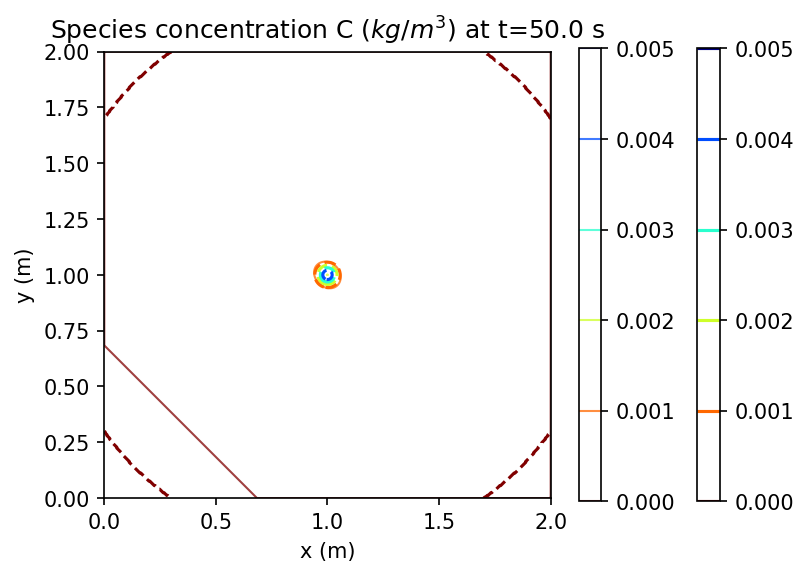

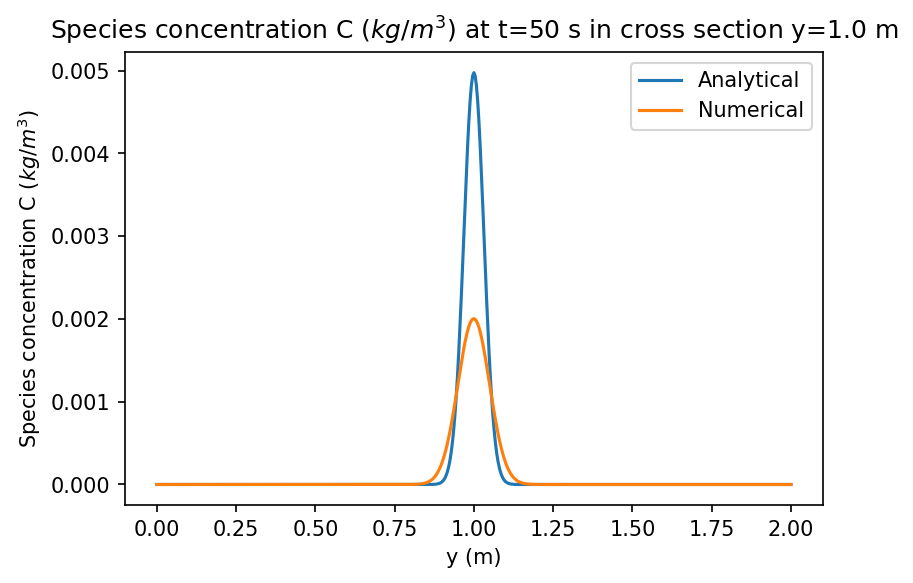

In [19]:
'''
    Numerical solution of diffusive and advective species transport
    on a finite 2D surface using given flow velocities
    
    Parameters:
    lx : Model length in x-direction (m)
    ly : Model length in y-direciotn (m)
    nx : Number of nodes in x-direction (m)
    ny : Number of nodes in y-direction (m)
    dx : Node distance in x-direction (m)
    dy : Node distance in y-direction (m)
    nt : Number of time steps (-)
    dt : Time step size (s)
    t  : Simulation time (s)
    D  : Dispersion coefficient (m^2/s)
    v_x : x-component of flow velocity (m/s)
    v_y : y-component of flow velocity (m/s)
'''

# Load required libraries
import time
import numpy
%matplotlib inline
from matplotlib import pyplot, cm
from numba import jit

time_start=time.time() # Time stamp for starting time

# Model parametrisation
lx = 2           # Model length in x-direction (m)
ly = lx           # Model length in y-direction (m)
nx = 501            # Node number in x-direction (-)
ny = nx          # Node number in y-direction (-)
dx = lx / (nx - 1) # Node distance in x-direction (m)
dy = dx           # Node distance in y-direction (m)

t = 50           # Simulation time (s)
D = 1e-5          # Dispersion coefficient (m^2/s)
v_x = -1e-2        # x-component of flow velocity (m/s)
v_y = v_x        # y-component of flow velocity (m/s)

# Initial coordinates of maximum concentration
xc = int(nx*3/4)
yc = int(ny*3/4)

# Advection scheme 
advscheme = 3 # 1: Central difference 
              # 2: Backward difference 
              # 3: Forward difference 
if advscheme == 1:
    print('Advection scheme: CD')
elif advscheme == 2:
    print('Advection scheme: BD')
else: 
    print('Advection scheme: FD')

# Adaptation of dt based on convergence and stability criteria
# CFL criterion with 10% safety margin (0.9): 
dt_CFL = dx / 2 / (abs(v_x) + abs(v_y)) * 0.9
# von Neumann criterion with 10% safety margin (0.9)
dt_NEU = dx**2/4/D * 0.9

print('dt_CFL:', dt_CFL, 'dt_NEU:', dt_NEU)

dt = min(dt_NEU, dt_CFL) # choose minimum dt as actual dt
if t <= dt: 
    dt = t
nt = int(numpy.ceil(t/dt))
dt = t/nt

C = numpy.zeros((nx,ny)) # Concentration of transported species (kg/m^3)
   
# Print time step information as well as stability and convergence criteria
print('dt: ', dt, 'nt: ', nt, 't: ', nt*dt)
Neumann = D * dt / dx**2 + D *dt / dy**2
print('Neumann: ', Neumann, ' <= 0.45')
Courant = abs(v_x) * dt / dx + abs(v_y) * dt / dy
print('Courant: ', Courant, ' <= 0.45')
Peclet = max(abs(v_x)*dx/D, abs(v_y)*dy/D)
print('Peclét: ', Peclet, ' <= 2.0', 'dx', dx, '-> dx_max', \
      2*D/max(abs(v_x), abs(v_y)))

# Initial concentration numerical model (C_max = 1 kg/m^3)
C = numpy.fromfunction(lambda i, j: \
    numpy.exp(-(i*dx - xc*dx)**2/D -(j*dy - yc*dy)**2/D), \
    (nx, ny), dtype=float)

# Analytical solution of advection-diffusion equation (C_max = 1 kg/m^3)
C_a = numpy.fromfunction(lambda i, j: \
     1/(4*t+1) * numpy.exp(-((i*dx-v_x*t-xc*dx)**2)/ \
                 (4*t+1)/D -((j*dy-v_y*t-yc*dy)**2)/ \
                 (4*t+1)/D), (nx, ny), dtype=float)

@jit
def advection_diffusion(C):
    # FD formulation of the 2D PDE
    for n in range(1,nt+1):  # Iterate over number of time steps
        Cn = C.copy()        # Copy previous concentrations to Cn
        for i in range(1, nx-1):     # Iterate over i-nodes (Dirichlet b.c.)
            for j in range(1, ny-1): # Iterate ober j-nodes (Dirichlet b.c.)
                # Diffusive term of advection-diffusion PDE
                C[i,j] = Cn[i,j] + \
                    D * dt / dx**2 * (Cn[i+1,j] - 2 * Cn[i,j] + Cn[i-1,j]) + \
                    D * dt / dy**2 * (Cn[i,j+1] - 2 * Cn[i,j] + Cn[i,j-1])
                # Advective term of advection-diffusion PDE
                # depending on choice of advscheme variable (1-3)
                # Effective porosity is equal to 1, so that v_i = q_i
                if advscheme == 1: # CD scheme
                    C[i,j] += - v_x * dt/2/dx * (Cn[i+1,j] - Cn[i-1,j]) - \
                        v_y * dt/2/dy * (Cn[i,j+1] - Cn[i,j-1])
                elif advscheme == 2: # BD scheme
                    C[i,j] += - v_x * dt/dx * (Cn[i,j] - Cn[i-1,j]) \
                        - v_y * dt/dy * (Cn[i,j] - Cn[i,j-1])
                else: # FD scheme
                    C[i,j] += - v_x * dt/dx * (Cn[i+1,j] - Cn[i,j]) \
                        - v_y * dt/dy * (Cn[i,j+1] - Cn[i,j])
    return C

C = advection_diffusion(C)

time_total = time.time()-time_start    # Time stamp at simulation end
print('Computation time:',time_total)  # Print computation time
                
# Graphical representation of results
x = numpy.linspace(0, lx, nx)
y = numpy.linspace(0, ly, ny)
X, Y = numpy.meshgrid(x, y)
fig = pyplot.figure(dpi=150)
ax = fig.gca(aspect=1)
nux = ax.contour(X, Y, numpy.transpose(C_a), 10, cmap=cm.jet_r,
     alpha=1, antialiased=True, linestyles='dashed',
                levels=[0.0, 0.001, 0.002, 0.003, 0.004, 0.005]);
nux2 = ax.contour(X, Y, numpy.transpose(C), 10, cmap=cm.jet_r,
     alpha=0.75, antialiased=True, linestyles='solid', linewidths=1, \
                  levels=[0.0, 0.001, 0.002, 0.003, 0.004, 0.005]);
cbnux = fig.colorbar(nux);
cbnux2 = fig.colorbar(nux2);
pyplot.title('Species concentration C ($kg/m^{3}$) at t='+\
             str(numpy.round(nt*dt,0))+' s');
ax.set_xlabel('x (m)');
ax.set_ylabel('y (m)');


# Graphical representation of cross section through y = 1 m 
x_ = numpy.linspace(0,2,nx) # Resolution: 1000 points(!)
fig2 = pyplot.figure(dpi=150)
aqp = pyplot.plot(x_,C_a[int(nx/2),:], label='Analytical')
aqp = pyplot.plot(x_,C[int(nx/2),:], label='Numerical');
pyplot.title('Species concentration C ($kg/m^{3}$) at t='+str(t) + \
             ' s in cross section y=1.0 m');
pyplot.xlabel('y (m)');
pyplot.ylabel('Species concentration C ($kg/m^{3}$)');
pyplot.legend();



In [7]:
numpy.sum(C)

19.634954084936172

In [8]:
numpy.sum(C_a)

19.6349540849362